# Playground for Building Function Approximator Tools

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Callable, Any
import math
from approximator.input_sampler import InputSampler
from approximator.model_based_fitter import ModelBasedFitter
import torch
from torch import nn
from overrides import overrides

%matplotlib inline
%load_ext tensorboard

%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single Variable Function Fitting
We fit various functions of single variable $\mathbb{R} \mapsto \mathbb{R}$ trained using MSE loss. We try:

1. a five-degree polynomial $f(x) = \frac{1}{2}x^5 - \frac{9}{4}x^4 + 4x^3 + 22x^2 - 48x + 1$
2. a sinusoidal function $f(x) = 4x\sin(2x - \frac{\pi}{2}) - \cos(3x)$
3. exponential: $f(x) = e^x$
4. logarithm: $f(x) = \ln x$

For each of these, we'll plot the true function and the fitted function to see how well it looks. We will bound the input to a certain range we care about.

In [11]:
def polynomial(x: float) -> float:
    return 0.2 * x ** 5 - 9 / 4 * x ** 4 + 4 * x ** 3 + 22 * x ** 2 - 48 * x + 1

In [12]:
def plot_fn(fn: Callable, x_min: float, x_max: float) -> None:
    x = np.linspace(x_min, x_max, 1000)
    y = [fn(i) for i in x]
    plt.plot(x, y)
    plt.title(fn.__name__)
    plt.show()

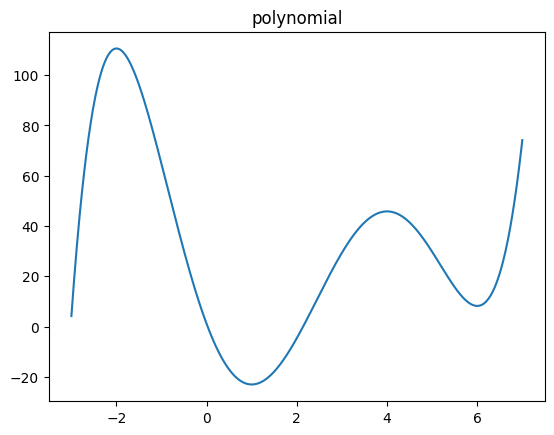

In [18]:
plot_fn(polynomial, -3, 7)

In [19]:
def plot_fn_with_fitted_fn(fn: Callable, fitted_fn: Callable, x_min: float, x_max: float) -> None:
    x = np.linspace(x_min, x_max, 1000)
    y = [fn(i) for i in x]
    plt.plot(x, y)
    y_fitted = [fitted_fn(i) for i in x]
    plt.plot(x, y_fitted, 'r')
    plt.title(fn.__name__)
    # add legend
    plt.legend(['original', 'fitted'])
    plt.show()

In [21]:
def dumb_fitted(x: float) -> float:
    return 60

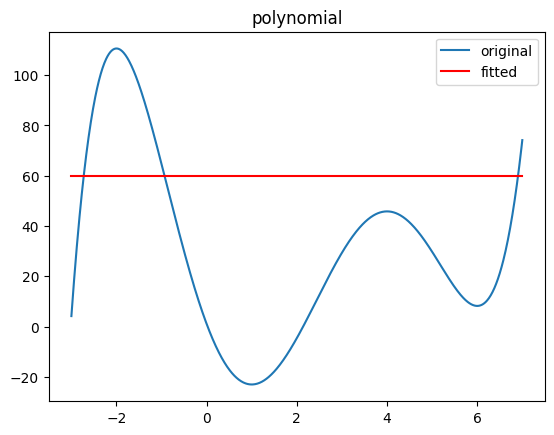

In [23]:
plot_fn_with_fitted_fn(polynomial, dumb_fitted, -3, 7)

In [25]:
# step 1, write the input sampler
class UniformScalarInputSampler(InputSampler):
    def __init__(self, min_val: float, max_val: float):
        self._min_val = min_val
        self._max_val = max_val
    
    def sample(self, batch_size: int) -> List[List[float]]:
        return np.random.uniform(self._min_val, self._max_val, (batch_size, 1)).tolist()
    

In [26]:
sampler = UniformScalarInputSampler(-3, 7)
inputs = sampler.sample(10)
inputs

[[6.53861381013599],
 [4.194722751534641],
 [-1.836699274255737],
 [0.17006700837014987],
 [6.020153285806707],
 [6.70332146329664],
 [3.405956133165639],
 [0.655192556646466],
 [-0.16302991027168656],
 [-0.31596908547442415]]

In [125]:
# step 2, write the fitter - we'll see how a single defined fitter performs on all our functions
class ScalarPolynomialFitter(ModelBasedFitter):
    @overrides
    def get_loss_fn(self) -> Callable:
        return nn.MSELoss()
    
    @overrides
    def construct_model(self) -> nn.Module:
        return nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    @overrides
    def init_other_state_variables(self):
        # compute min and max of inputs and outputs to roughly bin them to the range [0, 1]
        inputs, outputs = self._generate_batch(batch_size=10000)
        inputs = np.array(inputs, dtype=np.float32)
        outputs = np.array(outputs, dtype=np.float32)
        self._inputs_min = np.min(inputs, axis=0)
        self._inputs_max = np.max(inputs, axis=0)
        self._outputs_min = np.min(outputs)
        self._outputs_max = np.max(outputs)
    
    @overrides
    def get_optimizer(self) -> torch.optim.Optimizer:
        # return torch.optim.Adam(self._model.parameters(), lr=1e-6)
        return torch.optim.SGD(self._model.parameters(), lr=1e-4)
    
    @overrides
    def convert_input_to_tensor(self, *args) -> torch.Tensor:
        inputs = torch.tensor(args, dtype=torch.float32)
        # normalize the inputs
        return (inputs - self._inputs_min) / (self._inputs_max - self._inputs_min)
    
    @overrides
    def convert_output_to_tensor(self, output: Any) -> torch.Tensor:
        outputs = torch.tensor(output, dtype=torch.float32)
        # normalize the output
        return (outputs - self._outputs_min) / (self._outputs_max - self._outputs_min)
    
    @overrides
    def convert_model_output_to_function_output(self, model_output: torch.Tensor) -> Any:
        output = model_output.item()
        # denormalize the output
        return output * (self._outputs_max - self._outputs_min) + self._outputs_min
    

In [126]:
# init fitter 
polynomial_fitter = ScalarPolynomialFitter(
    fn=polynomial,
    input_sampler=sampler,
    name='polynomial_fitter',
    train_batch_size=64,
    eval_batch_size=10000,
    num_steps=10000,
    eval_steps=100,
)

In [127]:
# fit!
fitted_fn = polynomial_fitter.fit()

/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_14460/704521041.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (inputs - self._inputs_min) / (self._inputs_max - self._inputs_min)
/Users/sirjankafle/projects/function-approximator/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/sirjankafle/projects/function-approximator/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they ha

/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_14460/704521041.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (inputs - self._inputs_min) / (self._inputs_max - self._inputs_min)


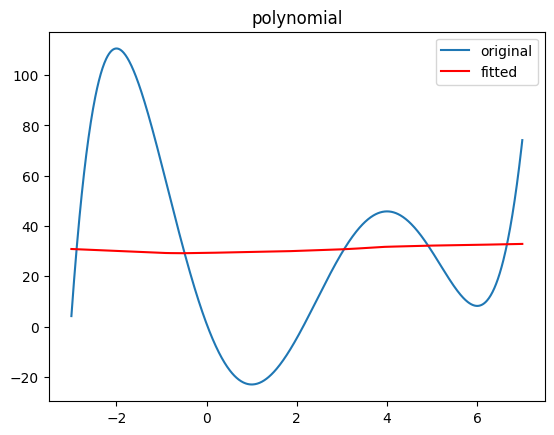

In [128]:
plot_fn_with_fitted_fn(polynomial, fitted_fn, -3, 7)

/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_14460/704521041.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (inputs - self._inputs_min) / (self._inputs_max - self._inputs_min)


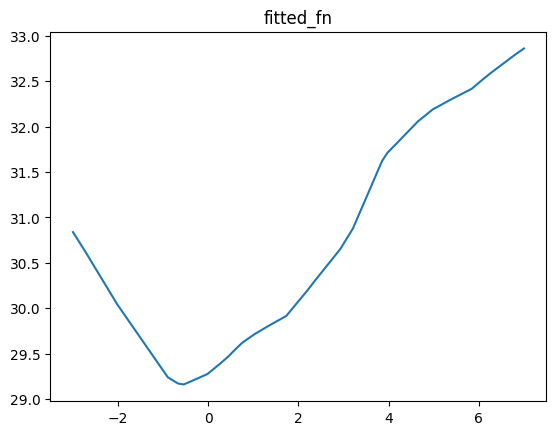

In [129]:
plot_fn(fitted_fn, -3, 7)

## Minimum Sample Size for Catching Coin Toss Cheaters
Inspired by this video: https://www.youtube.com/watch?v=XTcP4oo4JI4&t=1178s

Let, $p_f, p_b$ be the probabilities of a fair and biased coin respectively.

Let $\alpha, \beta$ be the desired FPR and effect size target respectively.

We want to find $n$ := the minimum sample size to satisfy those targets where the test is: identify a cheater (positive) if they hit more than $T$ heads ($T$ is determined based on those parameters).

Once we define a function, we'll fit it using the function approximator framework.

In [3]:
# utility matrix that caches n choose k values for up to MAX_N for faster computation
MAX_N = 1000

# M[n, k] n > 1, 0 <= k <= n
cached_n_choose_k = np.zeros((MAX_N + 1, MAX_N + 1))
for n in range(1, MAX_N + 1):
    for k in range(n + 1):
        cached_n_choose_k[n, k] = math.comb(n, k)

In [4]:
def binomial_pdf(n: int, p: float, k: float) -> float:
    return cached_n_choose_k[n, k] * p**k * (1-p)**(n-k)

In [5]:
def compute_min_threshold_for_alpha(p: float, alpha: float, n: int) -> int:
    # find the minimum T such that probability of hitting at least T heads on n tosses is <= alpha

    total_probability = 0

    # iterate backwards
    for t in range(n, -1, -1):
        total_probability += binomial_pdf(n, p, t)

        if total_probability > alpha:
            return t + 1
    
    # if we get here, something went wrong - the final probability should be 1 and alpha < 1
    raise ValueError(f"Ensure alpha is < 1.0")

In [6]:
def compute_statistical_power(p: float, n: int, t: int) -> float:
    total_probability = 0
    for k in range(t, n + 1):
        total_probability += binomial_pdf(n, p, k)
    
    return total_probability


In [7]:
def min_sample_for_test(p_f: float, p_b: float, alpha: float, beta: float) -> Optional[int]:
    # validation logic
    assert 0 <= p_f <= 1
    assert 0 <= p_b <= 1
    assert p_f < p_b
    assert 0 < alpha < 1
    assert 0 < beta < 1

    for n in range(1, MAX_N + 1):
        t = compute_min_threshold_for_alpha(p_f, alpha, n)
        power = compute_statistical_power(p_b, n, t)
        if power >= beta:
            return n
    
    return MAX_N + 1


In [8]:
min_sample_for_test(
    p_f=0.5,
    p_b=0.75,
    alpha=0.05,
    beta=0.8,
)

23

In [9]:
# static parameter values
parameter_values = {
    "p_f": 0.5,
    "p_b": 0.75,
    "alpha": 0.05,
    "beta": 0.8,
}

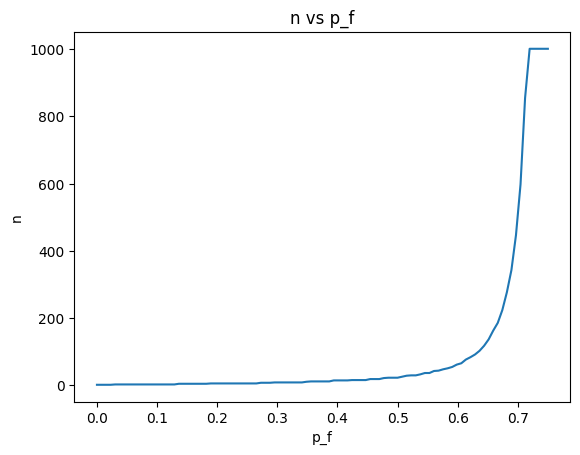

In [10]:
# plot n vs p_f fixing the other parameters
p_f = np.linspace(0, parameter_values["p_b"] - 0.0001, 100)
n_vals = np.array([min_sample_for_test(p_f, parameter_values["p_b"], parameter_values["alpha"], parameter_values["beta"]) for p_f in p_f])
plt.plot(p_f, n_vals)
plt.xlabel("p_f")
plt.ylabel("n")
plt.title("n vs p_f")
plt.show()

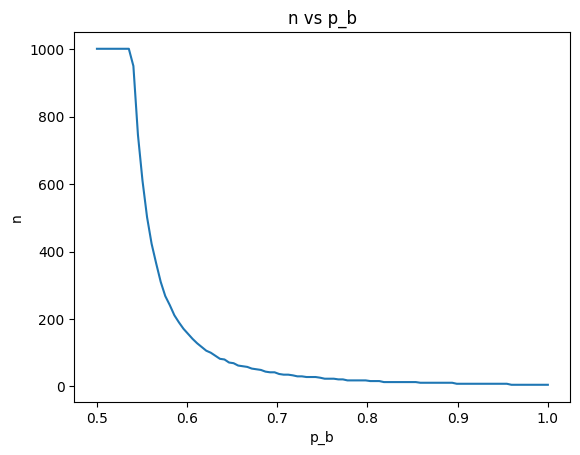

In [11]:
# plot n vs p_b fixing the other parameters
p_b = np.linspace(parameter_values["p_f"] + 0.0001, 1, 100)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], p_b, parameter_values["alpha"], parameter_values["beta"]) for p_b in p_b])
plt.plot(p_b, n_vals)
plt.xlabel("p_b")
plt.ylabel("n")
plt.title("n vs p_b")
plt.show()

In [12]:
min_sample_for_test(parameter_values["p_f"], 1.0, parameter_values["alpha"], parameter_values["beta"])

5

In [13]:
min_sample_for_test(0.0, parameter_values["p_f"], parameter_values["alpha"], parameter_values["beta"])

3

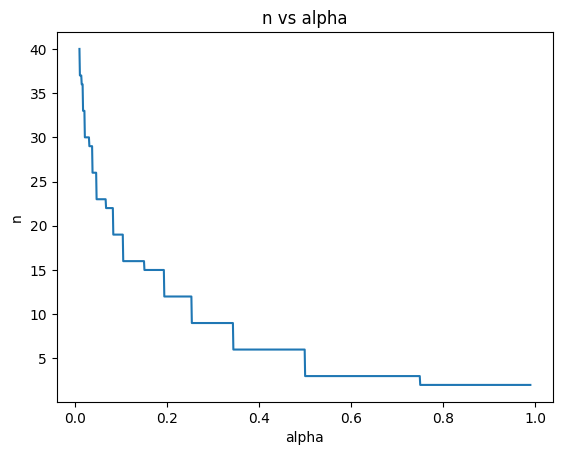

In [14]:
# plot n vs alpha fixing the other parameters
alpha = np.linspace(0.01, 0.99, 1000)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], parameter_values["p_b"], alpha, parameter_values["beta"]) for alpha in alpha])
plt.plot(alpha, n_vals)
plt.xlabel("alpha")
plt.ylabel("n")
plt.title("n vs alpha")
plt.show()

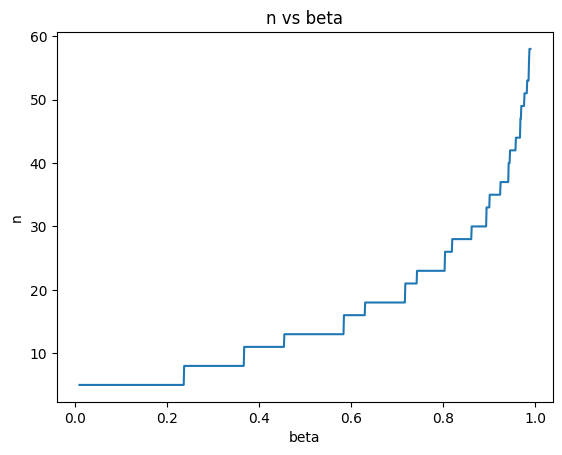

In [15]:
# plot n vs beta fixing the other parameters
beta = np.linspace(0.01, 0.99, 1000)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], parameter_values["p_b"], parameter_values["alpha"], beta) for beta in beta])
plt.plot(beta, n_vals)
plt.xlabel("beta")
plt.ylabel("n")
plt.title("n vs beta")
plt.show()

### Approximate this Function
We take a stab at approximating this function $f(p_f, p_b, \alpha, \beta) \mapsto \mathbb{Z}_+$

In [16]:
# imports
from approximator.fitter import Fitter
from approximator.input_sampler import InputSampler

In [46]:
# we write our custom input sampler
class MinSizeProblemInputSampler(InputSampler):
    def sample(self, batch_size: int) -> List[List[float]]:
        # sample p_f between 0 and 0.5
        p_f = np.random.uniform(0, 0.5, batch_size)
        # sample p_b between 0.6 and 1
        p_b = np.random.uniform(0.6, 1, batch_size)
        # sample alpha between 0.01 and 0.2
        alpha = np.random.uniform(0.01, 0.2, batch_size)
        # sample beta between 0.6 and 1.0
        beta = np.random.uniform(0.6, 1, batch_size)

        return [[p_f[i], p_b[i], alpha[i], beta[i]] for i in range(batch_size)]
        

In [47]:
sampler = MinSizeProblemInputSampler()
sampler.sample(5)

[[np.float64(0.22996795149331178),
  np.float64(0.6791661564120827),
  np.float64(0.1271251891675025),
  np.float64(0.9182504615853064)],
 [np.float64(0.1574902332545129),
  np.float64(0.7498227024914883),
  np.float64(0.12600922908079765),
  np.float64(0.9064796140424907)],
 [np.float64(0.18171207318700694),
  np.float64(0.6245276736563189),
  np.float64(0.05684704755977063),
  np.float64(0.6207554786374831)],
 [np.float64(0.35085580304341946),
  np.float64(0.7362705489803975),
  np.float64(0.17151466135302773),
  np.float64(0.8085501679859401)],
 [np.float64(0.07193348430840668),
  np.float64(0.8792543517904684),
  np.float64(0.1435609055367031),
  np.float64(0.975686824430248)]]